## Загрузим нужные библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from tqdm import tqdm_notebook  
from time import sleep 
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy. special import rel_entr

import scipy
from scipy.special import softmax
from scipy.signal import find_peaks
from scipy import stats
from scipy.signal import resample

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.feature_selection.relevance import calculate_relevance_table
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

# для построения моделей воспользуемся sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import recall_score, precision_score
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold




%matplotlib inline
import seaborn as sns

from lightgbm import LGBMClassifier
import lightgbm as lgbm


from catboost import CatBoostClassifier

import optuna 
from optuna.integration import OptunaSearchCV

from prophet import Prophet
from PIL import Image

import pickle

#from prophet import Prophet
from random import random

from torchvision.models.resnet import ResNet, BasicBlock
from torchvision.datasets import MNIST
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import time
from torch import nn, optim
from torch.optim import lr_scheduler

import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torchvision import models

import torch
from torch.utils.data import TensorDataset, DataLoader

import torch.nn.functional as F
from torch.optim import Adam
from torchsummary import summary


import random

import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
%matplotlib inline

In [2]:
def create_image_dataset(df, resize=False, size=(224, 224)):
    images = []
    for i in tqdm_notebook(df.index):
        w = df.loc[i].values
        h = w.reshape(w.shape[0], 1)
        image = w * h - (np.sqrt(1 - w**2) * np.sqrt(1 - h**2)) 
        if resize:
            image = Image.fromarray(image)
            image = image.resize(size)
            images.append(np.array(image))
        else:
            images.append(np.array(image))
    return np.array(images)

In [3]:


def save_images(images, filename='img_train.pkl'):
    output = open(filename, 'wb')
    pickle.dump(images, output)
    output.close()

def load_images(filename):
    pkl_file = open(filename, 'rb')
    imgs = pickle.load(pkl_file)
    pkl_file.close()
    return imgs

In [4]:
def mean_months(df): 
    mnts = ['2021-04', '2021-05', '2021-06','2021-07', '2021-08']
    for i in mnts:
        df[i] = 0
        n = 0
        for j in df.columns:
            if i in j and i != j:
                df[i] += data_time[j]
                n+=1
#         print(n)
#         print(data_time[i])
        df[i] = df[i]/n

In [5]:
def roll_mean(df, rolling_mean_size=5):
    df2 = df.copy()
    for i in tqdm_notebook(df2.index):
        data_i = df2.loc[i]
        index = data_i.index
        data_i = pd.DataFrame(data_i)
        data_i.columns = ['value']
        data_i.index = pd.to_datetime(data_i.index)
        data_i['roll_mean'] = data_i['value'].shift().rolling(rolling_mean_size).mean()
        df2.loc[i] = data_i['roll_mean']
    return df2

In [6]:
def roll_std(df, rolling_std_size=3):
    df2 = df.copy()
    for i in tqdm_notebook(df2.index):
        data_i = df2.loc[i]
        index = data_i.index
        data_i = pd.DataFrame(data_i)
        data_i.columns = ['value']
        data_i.index = pd.to_datetime(data_i.index)
        data_i['roll_std'] = data_i['value'].shift().rolling(rolling_std_size).std()
        df2.loc[i] = data_i['roll_std']
    return df2

In [7]:
def make_lag(df, lag=1):
    df2 = df.copy()
    for i in tqdm_notebook(df2.index):
        data_i = df.loc[i]
        index = data_i.index
        data_i = pd.DataFrame(data_i)
        data_i.columns = ['value']
        data_i.index = pd.to_datetime(data_i.index)
        data_i['lag'] = data_i['value'].shift(lag)
        df2.loc[i] = data_i['lag']
    return df2    

In [8]:
def search_anomaly(series, offset=0.5, method='std', number_std=3, rolling_size=5):
    data_i= series
    data_i = pd.DataFrame(data_i)
    data_i.index = pd.to_datetime(data_i.index)
    if method=='std':
        data_i.columns = ['value']
        data_i.index = pd.to_datetime(data_i.index)
        data_i['roll_mean'] = data_i['value'].shift().rolling(rolling_size).mean()
        data_i['roll_std'] = data_i['value'].shift().rolling(rolling_size).std()
        data_i['anomaly'] = (abs(data_i['value'] - data_i['roll_mean']) > (
                           data_i['roll_std'] * number_std)
                            )
        return data_i[data_i['anomaly'] == 1].index
    if method=='forest':
        clf = IsolationForest(random_state=0).fit(data_i)
        clf.offset_ = -offset
        pred_anomaly = clf.predict(data_i)
        data_i['anomaly'] = pred_anomaly
        return data_i[data_i['anomaly'] == -1].index

In [9]:
def replace_anomaly_mean(df, rolling_size=5, replace=False, number_std=3):
    for i in tqdm_notebook(df.index):
        df_2 = df.copy()
        data_i= df_2.loc[i]
        data_i = pd.DataFrame(data_i)
        data_i.index = pd.to_datetime(data_i.index)

        data_i.columns = ['value']
        data_i.index = pd.to_datetime(data_i.index)
        data_i['roll_mean'] = data_i['value'].shift().rolling(rolling_size).mean()
        data_i['roll_std'] = data_i['value'].shift().rolling(rolling_size).std()
        data_i['anomaly'] = (abs(data_i['value'] - data_i['roll_mean']) > (
                               data_i['roll_std'] * number_std)
                            )
        if replace==True:
            df_2.loc[i] = data_i['roll_mean']
        else:
            anom_ind = data_i[data_i['anomaly']==1].index
            data_i.loc[anom_ind, 'value'] =data_i.loc[anom_ind, 'roll_mean']
            df_2.loc[i] = data_i['value']
    return df_2

In [10]:
def coordinate(x):
    try:
        x = eval(x)['coordinates'][0][0]
        #print(len(x))
    except:
        x = eval(x)['geometries'][0]['coordinates'][0]
        #print(len(x))
    if len(x) >2:

        x = x[0]
    return x


In [11]:
def time_clean(df, method = 'arima', replace=False, order=(1, 1, 1), 
               anomaly=False, number_std=3, rolling_size=5):
    
    if method=='sarimax':
        for i in tqdm_notebook(df.index):
            data_i = df.loc[i]
            index = data_i.index
            # fit model
            model=sm.tsa.statespace.SARIMAX(data_i,order=order)
            yhat = model.fit(maxiter=250).predict(start='2021-04-15',end= 69)
            yhat.index = index
            #model_fit = model.fit()
            if replace:
    
                df.loc[i] = yhat
            else:
                ind = data_i[data_i == 0].index
                data_i[ind] = yhat[ind]
                if anomaly:
                    anomaly_index = search_anomaly(data_i, number_std=number_std, rolling_size=rolling_size)
                    data_i[anomaly_index] = yhat[anomaly_index]
                df.loc[i] = data_i
        
        
        results=model.fit(maxiter=250)
    
    if method == 'smothing':
        for i in tqdm_notebook(df.index):
            data_i = df.loc[i]
            index = data_i.index
            # fit model
            model = ExponentialSmoothing(data_i)
            model_fit = model.fit()
            yhat = model_fit.predict(1, len(data_i))
            yhat.index = index
            #model_fit = model.fit()
            if replace:
    
                df.loc[i] = yhat
            else:
                ind = data_i[data_i == 0].index
                data_i[ind] = yhat[ind]
                anomaly_index = search_anomaly(data_i)
                data_i[anomaly_index] = yhat[anomaly_index]
                df.loc[i] = data_i 
    
    if method == 'arima':
        for i in tqdm_notebook(df.index):
            data_i = df.loc[i]
            index = data_i.index
            # fit model
            model = ARIMA(data_i, order=order)
            yhat = model.fit().predict(1, len(data_i))
            yhat.index = index
            #model_fit = model.fit()
            if replace:
    
                df.loc[i] = yhat
            else:
                ind = data_i[data_i == 0].index
                data_i[ind] = yhat[ind]
                if anomaly:
                    anomaly_index = search_anomaly(data_i, number_std=number_std, rolling_size=rolling_size)
                    anomaly_index = anomaly_index.strftime('%Y-%m-%d')
                    data_i[anomaly_index] = yhat[anomaly_index]
                df.loc[i] = data_i
                
    if method == 'prophet':
        for i in tqdm_notebook(df.index):
            data_i = df.loc[i]
            index = data_i.index
            data_i = pd.DataFrame(data_i).reset_index()
            data_i.columns = ['ds', 'y']
            m = Prophet()
            m.fit(data_i)
            forecast = m.predict(data_i)
            yhat = forecast['yhat']
            yhat.index = index
            if replace:
                df.loc[i] = yhat
            else:
                ind = data_i[data_i == 0].index
                data_i[ind] = yhat[ind]
                df.loc[i] = data_i
    return df

In [12]:
def arima_clean(df, order=(1, 1, 1), number_std=3, rolling_size=5, season=(0,0,0,0)):
    df_1 = df.copy()
    df_2 = df.copy()
    total_aic = 0
    for i in tqdm_notebook(df.index):
        data_i = df.loc[i]
        index = data_i.index
        # fit model
        model = ARIMA(data_i, order=order, seasonal_order=season)
        model_fit = model.fit()
        yhat = model_fit.predict(1, len(data_i))
        yhat.index = index
        #model_fit = model.fit()
        df_1.loc[i] = yhat

        #anomaly_index = search_anomaly(data_i, number_std=number_std, rolling_size=rolling_size)
        #anomaly_index = anomaly_index.strftime('%Y-%m-%d')

        ind = data_i[data_i == 0].index   
        data_i[ind] = yhat[ind]
        df_2.loc[i] = data_i
#         df_3 = df_2.copy()
        #data_i[anomaly_index] = yhat[anomaly_index]
        #df_2.loc[i] = data_i
        total_aic += model_fit.aic
    return df_1, df_2, total_aic 

In [13]:
def arima_std(df):
    df_1 = df.copy()
    
    
    for i in tqdm_notebook(df.index):
        data_i = df.loc[i]
        index = data_i.index
        scaler = RobustScaler()
        # fit model
        
        yhat = scaler.fit_transform(data_i.values.reshape(-1, 1)).reshape(1, -1)[0]
        #yhat.index = index

        df_1.loc[i] = yhat
    return df_1

In [14]:
def resample_size(df, size):
    df_1 = pd.DataFrame(data=[[0]*size], columns=list(range(0, size)))
    
    
    for i in tqdm_notebook(df.index):
        data_i = df.loc[i]

        yhat = resample(data_i, size)
        
        df_1.loc[len(df_1.index)] = yhat
        
    return df_1.drop(0, axis=0).reset_index().drop('index', axis=1)

In [15]:
def resample_median(df, size=20, time='W'):
    df_1 = pd.DataFrame(data=[[0]*size], columns=list(range(0, size)))
    
    
    for i in tqdm_notebook(df.index):
        data_i = df.loc[i]
        data_i = pd.DataFrame(data_i)
        data_i.index = pd.to_datetime(data_i.index)

        yhat = data_i.resample(time).median()
       
        df_1.columns = yhat.index
        df_1.loc[len(df_1.index)] = yhat.values.reshape(1, -1)[0]
        
    return df_1.drop(0, axis=0)

In [16]:
def boxcox_clean(df):
    from scipy import stats
    from scipy.special import inv_boxcox
    df_1 = df.copy()
    l_dicts = {}
    
    for i in tqdm_notebook(df.index):
        data_i = df.loc[i]
        index = data_i.index
        #print(i)
        #p = sm.tsa.stattools.adfuller(data_i)[1]
        #if p > 0.05:
        ts, l = stats.boxcox(data_i)
        yhat = pd.Series(ts) 
        yhat.index = index
        l_dicts[i] = l   
        df_1.loc[i] = yhat

    return df_1, l_dicts

In [17]:
def boxcox_inv(df, d):
    from scipy import stats
    from scipy.special import inv_boxcox
    df_1 = df.copy()
    
    
    for i in tqdm_notebook(df.index):
        data_i = df.loc[i]
        index = data_i.index
        #print(i)
        #p = sm.tsa.stattools.adfuller(data_i)[1]
        #if p > 0.05:
        ts = inv_boxcox(data_i, d[i])
        yhat = pd.Series(ts) 
        yhat.index = index
        #l_dicts[i] = l   
        df_1.loc[i] = yhat

    return df_1

In [18]:
def replace_mean(df, rolling_size=7, replace=False,center=False, number_std=3):
    df_2 = df.copy()
    for i in tqdm_notebook(df.index):
        
        data_i= df.loc[i]
        data_i = pd.DataFrame(data_i)
        data_i.index = pd.to_datetime(data_i.index)

        data_i.columns = ['value']
        data_i.index = pd.to_datetime(data_i.index)
        data_i['roll_mean'] = data_i['value'].shift().rolling(rolling_size, center = center).mean()


        
        ind = data_i[data_i['value']==0.0001].index
        
       
        data_i.loc[ind, 'value'] =data_i.loc[ind, 'roll_mean']

        df_2.loc[i] = data_i['value'].fillna(0)
        #ind = data_i[data_i['value']==0].index

    return df_2

In [19]:

def score_recall(df, y):
    X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=42)
    clf = RandomForestClassifier(random_state=42, n_estimators = 300, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = recall_score(y_test, y_pred, average="macro", zero_division=0)
    return score

def furie(df):
    df_1 = df.copy()
    
    
    for i in tqdm_notebook(df.index):
        data_i = df.loc[i]
        index = data_i.index
        # fit model
        
        yhat = np.abs(np.fft.fft(data_i))
        #yhat.index = index
        #model_fit = model.fit()
        data_i = yhat
        df_1.loc[i] = data_i

        
    return df_1.iloc[:, :36]


def welch(df, size=36):
    df_1 = df.iloc[:, :size].copy()
    
    
    for i in tqdm_notebook(df.index):
        data_i = df.loc[i]
        index = data_i.index
        # fit model
        
        y = scipy.signal.welch(data_i)
        df_1.loc[i] = y[1]

        
    return df_1   

In [20]:
def arima_drop_clean(df, order=(0, 1, 1), season=(0,0,0,0)):
    df_1 = df.copy()
    df_1[df_1 == 0] = np.nan
    df_2 = df.copy()
    for i in tqdm_notebook(df.index):
        data_i = df_1.loc[i]
        df_i = df.loc[i]
        index = data_i.index
        # fit model
        model = ARIMA(data_i.dropna(), order=order, seasonal_order=season)
        yhat = model.fit().predict(1, len(data_i))
        yhat.index = index
        
        ind = df_i[df_i == 0].index   
        data_i[ind] = yhat[ind]
        
        df_1.loc[i] = data_i
        df_2.loc[i] = yhat

    return df_1, df_2

In [21]:
def soft_max(df):
    df_1 = df.copy()
    
    for i in tqdm_notebook(df.index):
        data_i = df_1.loc[i]
        index = data_i.index
        # fit model
        
        yhat = softmax(data_i)
        yhat.index = index
        df_1.loc[i] = yhat

    return df_1

In [22]:
def target_vectors(data, target): 
    df = data.copy()
    df['target'] = target

    target_0 = df[df['target']==0].median(axis=0)[:-1]

    target_1 = df[df['target']==1].median(axis=0)[:-1]

    target_2 = df[df['target']==2].median(axis=0)[:-1]

    target_3 = df[df['target']==3].median(axis=0)[:-1]

    target_4 = df[df['target']==4].median(axis=0)[:-1]

    target_5 = df[df['target']==5].median(axis=0)[:-1]

    target_6 = df[df['target']==6].median(axis=0)[:-1]

    targets = [target_0, target_1, target_2, target_3, target_4, target_5, target_6]
    return targets

In [23]:


def random_init(SEED):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    torch.backends.cudnn.enabled=False

SEED = 1
random_init(SEED)

In [24]:
def feat_dist_target(df1, df_soft, targets, targets_soft, size=70): 
    df = df1.copy()
    for i, target in tqdm_notebook(enumerate(targets)):
        ###df[f'ccf{i}'] = df.iloc[:, :size].apply(lambda x: (sm.tsa.stattools.ccf(np.abs(x), np.abs(target))).max()/100, axis=1)
        
        df[f'canberra_{i}'] = df.iloc[:, :size].apply(lambda x: scipy.spatial.distance.canberra(x, target)/100, axis=1)
               
        #df[f'correlation_{i}'] = df.iloc[:, :size].apply(lambda x: scipy.spatial.distance.correlation(x, target)/100, axis=1)
        
        #df[f'cosine_{i}'] = df.iloc[:, :size].apply(lambda x: scipy.spatial.distance.cosine(x, target)/100, axis=1)
        
        #df[f'euclidean_{i}'] = df.iloc[:, :size].apply(lambda x: scipy.spatial.distance.euclidean(x, target)/100, axis=1)
        
        
        #df[f'mean_sig_cor_{i}'] = df.iloc[:, :size].apply(lambda x: scipy.signal.correlate(x, target).mean()/100, axis=1)
        
        #df[f'kl_{i}'] = df_soft.iloc[:, :size].apply(lambda x: sum(rel_entr(x, targets_soft[i]))/100, axis=1)
        
    return df

In [25]:
def feat_ex(data):    
    
    df = data.copy()
#     df['mean'] = df.apply(lambda x: x.mean(), axis=1)
#     df['median'] = df.apply(lambda x: x.median(), axis=1)
#     df['std'] = df.apply(lambda x: x.std(), axis=1)
#     df['max'] = df.apply(lambda x: x.max(), axis=1)
#     df['min'] = df.apply(lambda x: x.min(), axis=1)
#     df['maxmin_diff'] = (df['max'] - df['min'])
    #df['abs_median'] = df.apply(lambda x: np.median(np.absolute(x - np.median(x))), axis=1)
    #df['IQR'] = df.apply(lambda x: ((np.percentile(x, 75) - np.percentile(x, 25))), axis=1)
    
#     df['var'] = df.apply(lambda x: x.var(), axis=1)#
#     df['cf'] = df.apply(lambda x: (np.max(np.abs(x))/np.sqrt(np.mean(x**2))), axis=1)#
#     df['rms'] = df.apply(lambda x: np.sqrt(np.mean(x**2)), axis=1)#                   
#     df['ptp'] = df.apply(lambda x: np.ptp(x), axis=1)#  
#     df['p'] = df.apply(lambda x: np.mean(x**2), axis=1)#  
#     df['pi'] = df.apply(lambda x: (np.sqrt(np.mean(x**2))/np.mean(x)), axis=1)#                    
#     df['ff'] = df.apply(lambda x: (np.max(np.abs(x))/np.mean(x)), axis=1)#
    
                        
#     df['peak_count'] = df.apply(lambda x: len(find_peaks(x)[0]), axis=1) 
#     df['skew'] = df.apply(lambda x: stats.skew(x), axis=1)
#     df['kurtosis'] = df.apply(lambda x: stats.kurtosis(x), axis=1)
#     df['sma'] = df.apply(lambda x: np.sum(abs(x)/len(x)), axis=1)
                                            
    return df

In [26]:
def make_data_train():
    df = pd.read_csv('train_dataset_train.csv')
    df['coords'] = df['.geo'].apply(lambda x: coordinate(x))
    df['longitude'] = df['coords'].apply(lambda x: round(x[1], 4))/1000
    df['latitude'] = df['coords'].apply(lambda x: round(x[0], 4))/1000
    df['area'] = df['area']/1000 
    data = df.drop(['id', '.geo', 'coords'], axis=1)
    
    data.columns = ['area'] + [i.split('_')[-1] for i in data.columns[1:-3]]+['target', 'longitude', 'latitude']
    data = data[sorted(data.columns)]
    data_time = data.iloc[:, 0:-4]
    return data, data_time

def make_data_test():
    df_test = pd.read_csv('test_dataset_test.csv')
    df_test['coords'] = df_test['.geo'].apply(lambda x: coordinate(x))
    df_test['longitude'] = df_test['coords'].apply(lambda x: round(x[1], 4))/1000
    df_test['latitude'] = df_test['coords'].apply(lambda x: round(x[0], 4))/1000
    df_test['area'] = df_test['area']/1000
    
    data_test = df_test.drop(['id', '.geo', 'coords'], axis=1)
    data_test.columns = ['area'] + [i.split('_')[-1] for i in data_test.columns[1:-2]]+['longitude', 'latitude']
    data_test = data_test[sorted(data_test.columns)]
    data_time_test = data_test.iloc[:, 0:-3]
    return data_test, data_time_test

In [27]:
def make_full_data(dataset, ts_train):
    data = dataset.copy()
    df_furie = furie(ts_train)
    df_welch = welch(ts_train)
    ts_train_roll_8 = roll_mean(ts_train, 8)
    ts_train_roll_8.dropna(axis=1, inplace=True)
    data_exfeat = feat_ex(ts_train)
    df_size40 = resample_size(ts_train, 40)
    df_size60 = resample_size(ts_train, 60)
    ts_train_roll_3 = roll_mean(ts_train, 3)
    ts_train_roll_3.dropna(axis=1, inplace=True)

    df_furie['median'] = df_furie.median(axis=1)/100
    df_welch['median'] = df_welch.median(axis=1)/100
    ts_train_roll_8['median'] = ts_train_roll_8.median(axis=1)
    ts_train_roll_3['median'] = ts_train_roll_3.median(axis=1)
    cols = data_exfeat.iloc[:, 70:].columns
    df_size40['median'] = df_size40.median(axis=1)
    df_size60['median'] = df_size60.median(axis=1)

    data['median_f'] = df_furie['median']
    data['median_w'] = df_welch['median']
    data['median_roll_8'] = ts_train_roll_8['median']
    
    data['median_roll_3'] = ts_train_roll_3['median']
    data['median_res_40'] = df_size40['median']
    data['median_res_60'] = df_size60['median']
    data[cols] = data_exfeat[cols]
    
    return data
    


In [28]:
def scored(y_test, y_pred):
    score = recall_score(y_pred, y_test, average="macro", zero_division=0)
    score2 = precision_score(y_pred, y_test, average="macro", zero_division=0)
    print(f'recall {score} precision {score2}')
    print(classification_report(y_pred, y_test))
    print(confusion_matrix(y_pred, y_test))

## Создадим тренировочный и тестовый датасет 

In [29]:
df_train, ts_train = make_data_train()
df_test, ts_test = make_data_test()

full_data = make_full_data(df_train.drop('target', axis=1), ts_train)
full_data_test = make_full_data(df_test, ts_test)

  0%|          | 0/4830 [00:00<?, ?it/s]

  0%|          | 0/4830 [00:00<?, ?it/s]

  0%|          | 0/4830 [00:00<?, ?it/s]

  0%|          | 0/4830 [00:00<?, ?it/s]

  0%|          | 0/4830 [00:00<?, ?it/s]

  0%|          | 0/4830 [00:00<?, ?it/s]

  0%|          | 0/2071 [00:00<?, ?it/s]

  0%|          | 0/2071 [00:00<?, ?it/s]

  0%|          | 0/2071 [00:00<?, ?it/s]

  0%|          | 0/2071 [00:00<?, ?it/s]

  0%|          | 0/2071 [00:00<?, ?it/s]

  0%|          | 0/2071 [00:00<?, ?it/s]

In [30]:
data_long = pd.DataFrame({0: full_data.values.flatten(),
                          1: np.arange(full_data.shape[0]).repeat(full_data.shape[1])})
print(data_long.shape)
settings_efficient = settings.EfficientFCParameters()

ex_features = extract_features(data_long, column_id=1, impute_function=impute, 
                                               default_fc_parameters=settings_efficient)


print(ex_features.shape)

y = df_train['target']
features = calculate_relevance_table(ex_features, y, ml_task='classification', multiclass=True, 
                                     n_significant=7, n_jobs =8)

features[features['relevant'] == True]

feats = list(features[features['relevant'] == True]['feature'])


data_long = pd.DataFrame({0: full_data_test.values.flatten(),
                          1: np.arange(full_data_test.shape[0]).repeat(full_data_test.shape[1])})
print(data_long.shape)
settings_efficient = settings.EfficientFCParameters()

ex_features_test = extract_features(data_long, column_id=1, impute_function=impute, 
                                               default_fc_parameters=settings_efficient)


print(ex_features_test.shape)

(381570, 2)


Feature Extraction: 100%|███████████████████████| 40/40 [00:19<00:00,  2.04it/s]


(4830, 783)
(163609, 2)


Feature Extraction: 100%|███████████████████████| 40/40 [00:08<00:00,  4.71it/s]


(2071, 783)


In [31]:
ex_train_7 = full_data.join(ex_features[feats[:7]], how='left', rsuffix='_ex')
ex_test_7 = full_data_test.join(ex_features_test[feats[:7]], how='left', rsuffix='_ex')
cols = list(ex_train_7.columns)

cols[-7:] = [f'coef_{i}' for i in range(1, 8)]
ex_train_7.columns = cols
ex_test_7.columns = cols

In [32]:
ex_train_5 = full_data.join(ex_features[feats[:5]], how='left', rsuffix='_ex')
ex_test_5 = full_data_test.join(ex_features_test[feats[:5]], how='left', rsuffix='_ex')
cols = list(ex_train_5.columns)

cols[-5:] = [f'coef_{i}' for i in range(1, 6)]
ex_train_5.columns = cols
ex_test_5.columns = cols

## LightGBMClassifier

In [33]:

# cl = lgbm.LGBMClassifier(objective='recall', random_state=42, n_estimators=270, 
#                              n_jobs=-1, class_weight={0:10,1:1, 2:1, 3:1, 4:1, 5:1, 6:1})


    

In [34]:
filename = 'sample_solution.csv'
df_predictions = pd.read_csv(filename).drop('crop', axis=1)


In [35]:
y = df_train['target']

In [36]:
X = ex_train_7

cl = lgbm.LGBMClassifier(objective='recall', random_state=42, 
                         n_estimators=270, n_jobs=-1, class_weight={0:10,1:1, 2:1, 3:1, 4:1, 5:1, 6:1})
cl.fit(X, y)
y_pred = cl.predict(ex_test_7)
df_predictions['lgbm_1'] = y_pred

In [37]:
X = df_train.drop('target', axis=1)

cl = lgbm.LGBMClassifier(objective='recall', random_state=42, 
                         n_estimators=270, n_jobs=-1, class_weight={0:10,1:1, 2:1, 3:1, 4:1, 5:1, 6:1})
cl.fit(X, y)
y_pred = cl.predict(df_test)
df_predictions['lgbm_2'] = y_pred

In [38]:
X = ex_train_5

cl = lgbm.LGBMClassifier(objective='recall', random_state=42, 
                         n_estimators=270, n_jobs=-1, class_weight={0:10,1:1, 2:1, 3:1, 4:1, 5:1, 6:1})
cl.fit(X, y)
y_pred = cl.predict(ex_test_5)
df_predictions['lgbm_3'] = y_pred

In [39]:
X = full_data

cl = lgbm.LGBMClassifier(objective='recall', random_state=42, 
                         n_estimators=270, n_jobs=-1, class_weight={0:10,1:1, 2:1, 3:1, 4:1, 5:1, 6:1})
cl.fit(X, y)
y_pred = cl.predict(full_data_test)
df_predictions['lgbm_4'] = y_pred

In [40]:

#df_predictions['lgbm_ts'] = y_pred



# filename = 'sample_solution.csv'

# submission = pd.read_csv(filename)

#df_predictions['t'] = df_predictions.apply(lambda x: int(x.value_counts().index[0]), axis=1)
#df_predictions

#submission['crop'] = y_pred
#submission.to_csv('./my_submission.csv', index=False)

In [41]:
df_predictions

,id,lgbm_1,lgbm_2,lgbm_3,lgbm_4
0,611,3,3,3,3
1,6417,2,2,2,2
2,3352,3,3,3,3
3,4224,1,1,1,1
4,3102,6,6,6,6
...,...,...,...,...,...
2066,1743,5,5,5,5
2067,3968,3,3,3,3
2068,3809,2,2,2,2
2069,5485,6,6,6,6


In [42]:
from torch.utils.data.sampler import Sampler
from torch.utils.data.sampler import BatchSampler

class CustomSampler(Sampler):
    def __init__(self, dataset, seed):
        self.seed = seed
        halfway_point = int(len(dataset))
        self.lst = list(range(halfway_point))

        
    def __iter__(self):
        random.seed(self.seed)
        random.shuffle(self.lst)
        
        return iter(self.lst)
    
    def __len__(self):
        return len(self.lst)
    
    


In [43]:


class CustomBatchSampler(Sampler):
    def __init__(self, dataset, batch_size, seed):
        lenght = len(dataset)  
        self.indices = list(range(lenght))
        self.batch_size = batch_size
        self.seed = seed
    
    def __iter__(self):
        random.seed(self.seed)
        random.shuffle(self.indices)
        self.indices
        
       
        batch_split = torch.split(torch.tensor(self.indices), self.batch_size)
        
        batches = [batch.tolist() for batch in list(batch_split)]
        random.shuffle(batches)
        return iter(batches)
    
    def __len__(self):
        return len(indices) // self.batch_size

In [44]:
def make_train_loader(X_train, y_train,   batch_size=64, 
                      input_shape=(-1, 1, 79, 79),  image=False, seed=SEED):
    
    
    X_train = X_train.reshape(*input_shape)
    #print(X_train.shape)
    X_tensor = torch.tensor(X_train.astype(np.float32))
    #if image:
    #    X_tensor = X_tensor/255
    
    y_tensor = torch.tensor(y_train.astype(np.long))       
    dataset = TensorDataset(X_tensor, y_tensor)
    sampler= CustomSampler(dataset, seed=seed)
    batch_sampler2 = BatchSampler(sampler=sampler, batch_size=batch_size, drop_last=False)
    loader = DataLoader(dataset, batch_sampler=batch_sampler2)
    return loader

def make_test_loader(X_test, y_test=None, method='train', input_shape=(-1, 1, 79, 79), 
                                     batch_size=64, image=True, seed=SEED):
    
    X_test = X_test.reshape(*input_shape)
    #print(X_test.shape)
    X_tensor = torch.tensor(X_test.astype(np.float32))
    #if image:
    #    X_tensor = X_tensor/255
    if method == 'train':
        y_tensor = torch.tensor(y_test.astype(np.long)) 
    else:
        y_tensor = torch.zeros(len(X_test), dtype=torch.long)

    dataset = TensorDataset(X_tensor, y_tensor)
    
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=False)
    return loader

In [45]:
def make_binary_target(target, label):
    bin_target = target.apply(lambda x: 1 if x == label else 0)
    return bin_target

In [46]:
def train(model, train_loader,optimizer, scheduler,  epochs=30, loss_function=nn.CrossEntropyLoss(),
         batch_size = 64):   
    
    random_init(SEED)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    #losses = []
    batches = len(train_loader)
    

    for epoch in range(epochs):
        total_loss = 0
        progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)
        model.train()
        for i, batch_35  in progress:
            optimizer.zero_grad()
            inputs_img, target_img = batch_35
            inputs_img = inputs_img.to(device)
            target_img = target_img.to(device)
            pred = model(inputs_img)
            #target_img = target_img.unsqueeze(1)  # add binary
            loss = loss_function(pred, target_img) #.float()
            loss.backward()
            optimizer.step()
            current_loss = loss.item()
            total_loss += current_loss
            progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))
        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}")
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    return model

def predict_proba(model, val_loader, y=None):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.eval()
    predictions = []
    
    with torch.no_grad():
 
        for i, batch_image   in enumerate(val_loader):
                          
            inputs_img, target_img = batch_image
            inputs_img = inputs_img.to(device)
            target_img = target_img.to(device)        
            outputs = model.to(device)(inputs_img)
            predictions.append(outputs.detach().cpu().numpy())
            

    predictions = np.concatenate(predictions)
    return predictions

def predict(model, val_loader, y=None):
    predictions = predict_proba(model, val_loader, y) 
    predictions = predictions.argmax(axis=1)
    return predictions

In [47]:
images = df_train.drop('target', axis=1)


In [48]:
train_images = create_image_dataset(images)
test_images = create_image_dataset(df_test)

  0%|          | 0/4830 [00:00<?, ?it/s]

  0%|          | 0/2071 [00:00<?, ?it/s]

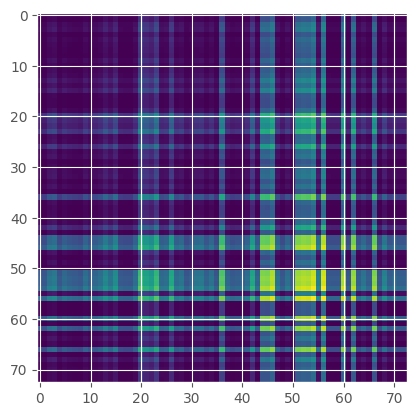

In [49]:
plt.imshow(train_images[100])

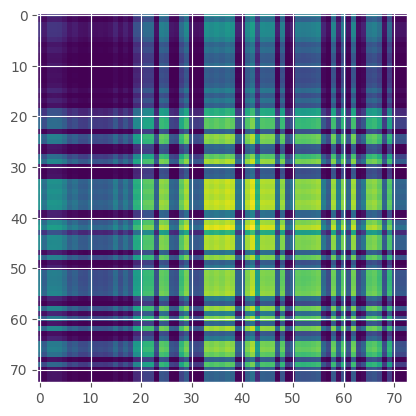

In [50]:
plt.imshow(test_images[100])

## ResNet 18

In [51]:
class ModelResnet(nn.Module):
    def __init__(self, resnet):
        super(ModelResnet, self).__init__()
        self.resnet = resnet
        #self.fc1 = nn.Linear(128, 700)
        #self.fc2 = nn.Linear(700, 70)
        self.classifier = nn.Linear(128, 7)
        #self.classifier = nn.Linear(1536, 7)
        
    def forward(self, x):
        x = self.resnet(x)
        x = x.view(-1, x.shape[1] * x.shape[2] *x.shape[3])
        #x = F.relu(self.fc1(x))
        
        x = self.classifier(x)
        return x

In [54]:

X = train_images
y=df_train['target'].values

X_test = test_images

image_train_loader = make_train_loader(X, y, input_shape=(-1, 1,73, 73), batch_size=32)

image_val_loader = make_test_loader(X_test, input_shape=(-1, 1,73, 73), batch_size=32, method='test')

random_init(SEED)

resnet_18 =  models.resnet18()
resnet_18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
features=list(resnet_18.children())[:-4]
resnet_18=nn.Sequential(*features)
resnet_18.avgpool= nn.AdaptiveAvgPool2d(output_size=(1, 1))


optimizer = optim.Adam(resnet_18.parameters(), lr=0.001, betas=(0.9, 0.99))
#weights = [5.9619, 0.017]  # epoch=60 weights=[0.017, 4.9619]

scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.9)

resnet = ModelResnet(resnet_18)
model = train(resnet, train_loader=image_train_loader, epochs=220, 
                                          loss_function=nn.CrossEntropyLoss(),
         optimizer=optimizer, scheduler=scheduler)

model.eval()
preds_cnn = predict(model, image_val_loader)


df_predictions['resnet'] = preds_cnn
torch.save(model.state_dict(), 'weights_only_resnet.pth')

Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 1/220, training loss: 0.517968548992217


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 2/220, training loss: 0.2545812307604101


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 3/220, training loss: 0.2103726477516408


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 4/220, training loss: 0.1745238658410824


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 5/220, training loss: 0.16209071788270743


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 6/220, training loss: 0.13514227234443885


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 7/220, training loss: 0.13523860407734153


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 8/220, training loss: 0.11313600394726786


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 9/220, training loss: 0.09438928605877603


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 10/220, training loss: 0.09925039841589943


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 11/220, training loss: 0.09262719263464508


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 12/220, training loss: 0.08201072446459176


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 13/220, training loss: 0.08053488304086079


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 14/220, training loss: 0.0783566404874159


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 15/220, training loss: 0.05353387327099971


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 16/220, training loss: 0.055932895340555844


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 17/220, training loss: 0.05642506681900743


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 18/220, training loss: 0.05410773346558312


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 19/220, training loss: 0.045701399443991826


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 20/220, training loss: 0.05015251422856028


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 21/220, training loss: 0.03871474703712179


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 22/220, training loss: 0.04714548003409576


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 23/220, training loss: 0.03367031619125447


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 24/220, training loss: 0.029326669217260026


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 25/220, training loss: 0.027233919376254526


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 26/220, training loss: 0.02923669676768242


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 27/220, training loss: 0.023438674919708132


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 28/220, training loss: 0.024437662032864592


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 29/220, training loss: 0.023168269907963147


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 30/220, training loss: 0.0214824229787221


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 31/220, training loss: 0.016163737816113164


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 32/220, training loss: 0.018425779145007447


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 33/220, training loss: 0.015598989367818103


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 34/220, training loss: 0.023881177702804547


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 35/220, training loss: 0.015470517532119761


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 36/220, training loss: 0.01256875409043104


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 37/220, training loss: 0.008617197786147909


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 38/220, training loss: 0.010744395521076224


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 39/220, training loss: 0.018157030403149924


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 40/220, training loss: 0.00927548410389449


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 41/220, training loss: 0.0068115224294281185


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 42/220, training loss: 0.016768692283342216


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 43/220, training loss: 0.010575080583016974


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 44/220, training loss: 0.011700886647665675


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 45/220, training loss: 0.008515948722283942


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 46/220, training loss: 0.010042399461172977


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 47/220, training loss: 0.00430098543944306


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 48/220, training loss: 0.006850651027449709


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 49/220, training loss: 0.007813792855367804


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 50/220, training loss: 0.0031584545777993437


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 51/220, training loss: 0.004188702651260988


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 52/220, training loss: 0.00818969444922998


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 53/220, training loss: 0.006237207325013502


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 54/220, training loss: 0.010878184150240618


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 55/220, training loss: 0.009768185533223896


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 56/220, training loss: 0.0029032279930805284


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 57/220, training loss: 0.002167482810948408


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 58/220, training loss: 0.005405808953643123


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 59/220, training loss: 0.007391035306037693


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 60/220, training loss: 0.003745283705601777


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 61/220, training loss: 0.003245619350833439


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 62/220, training loss: 0.01023845722037676


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 63/220, training loss: 0.004544544795657962


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 64/220, training loss: 0.0032230323518430567


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 65/220, training loss: 0.001045578333099345


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 66/220, training loss: 0.004197701615966018


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 67/220, training loss: 0.005409610562087407


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 68/220, training loss: 0.003145410975619429


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 69/220, training loss: 0.003446675843689498


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 70/220, training loss: 0.003528238070044753


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 71/220, training loss: 0.0029164925164624814


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 72/220, training loss: 0.0018499600412405022


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 73/220, training loss: 0.0026599898231728465


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 74/220, training loss: 0.0009354386189407037


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 75/220, training loss: 0.004665963892195264


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 76/220, training loss: 0.003155588204371095


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 77/220, training loss: 0.0017371250877664917


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 78/220, training loss: 0.002628552688539933


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 79/220, training loss: 0.0015336196003098192


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 80/220, training loss: 0.001997590873934736


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 81/220, training loss: 0.002384277680867185


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 82/220, training loss: 0.0007027271690848592


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 83/220, training loss: 0.0003951597256360064


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 84/220, training loss: 0.002053660710187265


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 85/220, training loss: 0.0009160441290475398


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 86/220, training loss: 0.0006542438879466095


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 87/220, training loss: 0.0012784508784751242


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 88/220, training loss: 0.0003635998558133936


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 89/220, training loss: 0.0017924954310656659


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 90/220, training loss: 0.0035894678948780166


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 91/220, training loss: 0.003391278062079569


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 92/220, training loss: 0.0008799905754974273


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 93/220, training loss: 0.00046355897011501337


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 94/220, training loss: 0.0002917211307833335


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 95/220, training loss: 0.001336572054067753


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 96/220, training loss: 0.0010627948125912607


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 97/220, training loss: 0.0014836185295497135


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 98/220, training loss: 0.00033914070438234356


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 99/220, training loss: 0.001049370939798737


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 100/220, training loss: 0.00048228208192121867


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 101/220, training loss: 0.0003544374103753308


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 102/220, training loss: 0.0004678229918422614


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 103/220, training loss: 0.0008628860368061462


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 104/220, training loss: 0.00026190667825399063


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 105/220, training loss: 0.00015389513082602618


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 106/220, training loss: 0.00020766878262762982


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 107/220, training loss: 0.0002394937927546446


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 108/220, training loss: 0.0003838043530476056


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 109/220, training loss: 0.0004544880576572452


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 110/220, training loss: 0.00036019445712933904


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 111/220, training loss: 0.00019326564868618558


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 112/220, training loss: 0.0007556376090509946


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 113/220, training loss: 0.00023486958167232174


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 114/220, training loss: 0.00026697651329287445


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 115/220, training loss: 0.0002002351336297868


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 116/220, training loss: 0.0005024484308759932


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 117/220, training loss: 0.0002806235866799229


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 118/220, training loss: 0.00018337437941588498


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 119/220, training loss: 0.00023980388359391418


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 120/220, training loss: 9.861650464368505e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 121/220, training loss: 0.0001257452676905597


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 122/220, training loss: 0.0001477106835885187


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 123/220, training loss: 6.800066122671687e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 124/220, training loss: 0.00015452324656290865


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 125/220, training loss: 0.00017595926315544115


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 126/220, training loss: 7.41001238638519e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 127/220, training loss: 0.00010747211140580283


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 128/220, training loss: 7.312204162184004e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 129/220, training loss: 0.00023821307219642397


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 130/220, training loss: 8.154386338919601e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 131/220, training loss: 5.239368081506263e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 132/220, training loss: 4.363928114166479e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 133/220, training loss: 5.1390261015868175e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 134/220, training loss: 7.480339501931752e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 135/220, training loss: 3.593135299422481e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 136/220, training loss: 0.00016417249081248112


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 137/220, training loss: 0.0001497504678797445


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 138/220, training loss: 6.128935285612186e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 139/220, training loss: 5.379989359528356e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 140/220, training loss: 3.6818348173364216e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 141/220, training loss: 2.815437215572003e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 142/220, training loss: 3.3927604968596745e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 143/220, training loss: 7.228797521115335e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 144/220, training loss: 4.912042868153434e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 145/220, training loss: 2.8515538732736238e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 146/220, training loss: 2.335523264950977e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 147/220, training loss: 5.156422301580513e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 148/220, training loss: 3.85549830168762e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 149/220, training loss: 2.027326264691968e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 150/220, training loss: 2.6411701132898896e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 151/220, training loss: 6.487881148059868e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 152/220, training loss: 6.008352572027301e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 153/220, training loss: 2.6177286306076273e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 154/220, training loss: 3.7980719178039785e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 155/220, training loss: 1.804692281451248e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 156/220, training loss: 2.601298633590278e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 157/220, training loss: 2.4035082211316e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 158/220, training loss: 1.4169253968278202e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 159/220, training loss: 2.1500819000281406e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 160/220, training loss: 2.5119165400532352e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 161/220, training loss: 1.5260812174738442e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 162/220, training loss: 2.3972911847353833e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 163/220, training loss: 1.1361002620352813e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 164/220, training loss: 4.892154991403425e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 165/220, training loss: 1.1179449572578442e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 166/220, training loss: 1.2127224691774499e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 167/220, training loss: 1.3299906087519313e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 168/220, training loss: 3.243091653708111e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 169/220, training loss: 1.622142365068907e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 170/220, training loss: 1.655610820997279e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 171/220, training loss: 1.2468537645433167e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 172/220, training loss: 1.3090839283844412e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 173/220, training loss: 2.2628310296640366e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 174/220, training loss: 8.321577327204683e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 175/220, training loss: 9.797278476944725e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 176/220, training loss: 1.0632219109297784e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 177/220, training loss: 9.644597135573482e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 178/220, training loss: 9.583037254495573e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 179/220, training loss: 9.146693298890682e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 180/220, training loss: 8.695766990853529e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 181/220, training loss: 1.2465381241811986e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 182/220, training loss: 1.1108755559039099e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 183/220, training loss: 5.617530749737094e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 184/220, training loss: 7.1518833749827455e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 185/220, training loss: 6.194867885234083e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 186/220, training loss: 1.0272377491767338e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 187/220, training loss: 1.0205628435213063e-05


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 188/220, training loss: 7.227067500621732e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 189/220, training loss: 5.953404196278771e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 190/220, training loss: 6.104419206706293e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 191/220, training loss: 8.597565163244934e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 192/220, training loss: 5.984554389438047e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 193/220, training loss: 6.752455973829932e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 194/220, training loss: 6.185296309537224e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 195/220, training loss: 5.8600109522353554e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 196/220, training loss: 5.633618806410559e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 197/220, training loss: 4.624595059617273e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 198/220, training loss: 5.608684812091721e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 199/220, training loss: 4.275273401854005e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 200/220, training loss: 4.5214349518646e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 201/220, training loss: 3.466876353738088e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 202/220, training loss: 3.125705603302861e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 203/220, training loss: 3.4418851233667076e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 204/220, training loss: 3.212238688612335e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 205/220, training loss: 2.564398530075356e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 206/220, training loss: 2.8312046528892385e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 207/220, training loss: 3.5953646645429524e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 208/220, training loss: 3.171982227372037e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 209/220, training loss: 5.08922560464614e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 210/220, training loss: 2.9781578345685055e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 211/220, training loss: 2.046930955660456e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 212/220, training loss: 4.032703078632497e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 213/220, training loss: 2.941913517163914e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 214/220, training loss: 3.2504451174556668e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 215/220, training loss: 3.1177227298265534e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 216/220, training loss: 2.74298728785598e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 217/220, training loss: 5.347809967445496e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 218/220, training loss: 3.0437008868432634e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 219/220, training loss: 2.9352131366221216e-06


Loss:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 220/220, training loss: 1.839284609864321e-05


NameError: name 'y_pred_cnn' is not defined

In [55]:
df_predictions['resnet'] = preds_cnn

In [ ]:
torch.cuda.empty_cache()

## Submit

In [56]:
filename = 'sample_solution.csv'

submission = pd.read_csv(filename)

df_predictions['t'] = df_predictions.apply(lambda x: int(x.value_counts().index[0]), axis=1)


submission['crop'] = df_predictions['t']
submission.to_csv('./my_submission.csv', index=False)





# cl.fit(X, y)

# pred = cl.predict(df_dist_test)

# filename = 'sample_solution.csv'

# submission = pd.read_csv(filename)

# submission['crop'] = pred
# submission.to_csv('./my_submission.csv', index=False)

In [57]:
df_predictions

,id,lgbm_1,lgbm_2,lgbm_3,lgbm_4,resnet,t
0,611,3,3,3,3,3,3
1,6417,2,2,2,2,2,2
2,3352,3,3,3,3,3,3
3,4224,1,1,1,1,1,1
4,3102,6,6,6,6,6,6
...,...,...,...,...,...,...,...
2066,1743,5,5,5,5,5,5
2067,3968,3,3,3,3,3,3
2068,3809,2,2,2,2,2,2
2069,5485,6,6,6,6,6,6
